<a href="https://colab.research.google.com/github/derrickgzq/yenheranalysis/blob/main/Yenher_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required libraries

In [ ]:
install.packages('fpp3')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘warp’, ‘BH’, ‘Rcpp’, ‘distributional’, ‘progressr’, ‘slider’, ‘anytime’, ‘fable’, ‘fabletools’, ‘feasts’, ‘tsibble’, ‘tsibbledata’




In [ ]:
install.packages('quantmod')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’




In [ ]:
install.packages('urca')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Calling libraries

In [ ]:
library(fpp3)
library(readr)
library(quantmod)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following object is masked from ‘package:tsibble’:

    index


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



################################### WARNING ###################################
# We noticed you have dplyr installed. The dplyr lag() function breaks how    #
# base R's lag() function is supposed to work, which breaks lag(my_xts).      #
#                                                                             #
# Calls to lag(my_xts) that you enter or source() into this session won't     #
# work correctly.                                                             #
#                                                                             #
# All package code is unaffected because it is protected by the R namespace   #
# mechanism.                                                                  #
#                                  

# Forecasting of Yenher's earnings 

Fetching dataset

In [ ]:
url = 'https://raw.githubusercontent.com/derrickgzq/yenheranalysis/main/yenher%20pl%20statement.csv'
yenher = read_csv(url)

Rows: 7 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Date
dbl (2): Sales, NetProfit

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
yenher

Date,Sales,NetProfit
<chr>,<dbl>,<dbl>
3/31/2021,58786254,4937613
6/30/2021,67191499,5993644
9/30/2021,66236962,4282637
12/31/2021,71194928,5623225
3/31/2022,76088347,4912869
6/30/2022,102246197,6134572
9/30/2022,98200321,5469771


Convert it to tsibble object

In [ ]:
yenherdata = yenher %>% mutate(Date = yearmonth(Date)) %>% as_tsibble(index = Date)
yenherdata

Date,Sales,NetProfit
<mth>,<dbl>,<dbl>
2021 Mar,58786254,4937613
2021 Jun,67191499,5993644
2021 Sep,66236962,4282637
2021 Dec,71194928,5623225
2022 Mar,76088347,4912869
2022 Jun,102246197,6134572
2022 Sep,98200321,5469771


A brief visualization on its Sales and Net Profit

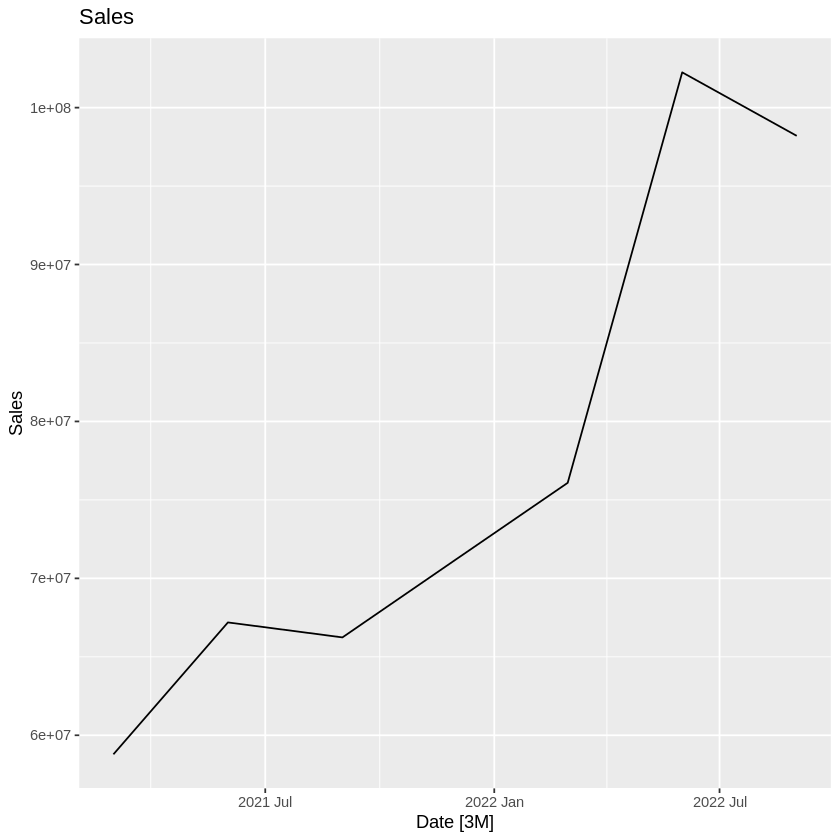

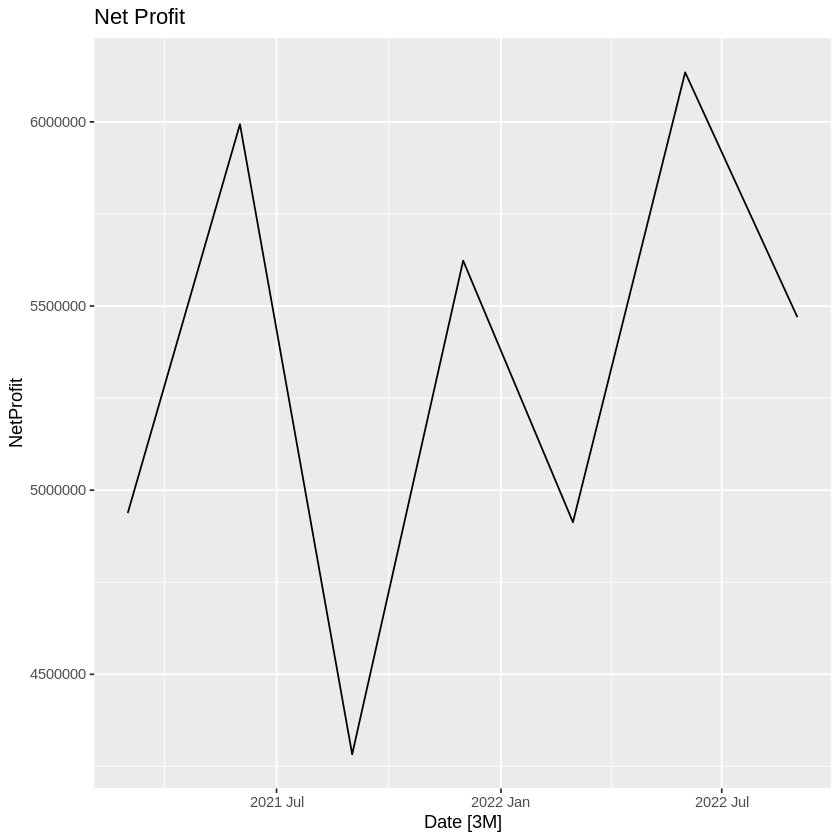

In [ ]:
par(mfrow = c(1,2))
autoplot(yenherdata, Sales) +
  ggtitle('Sales')
autoplot(yenherdata, NetProfit) +
  ggtitle('Net Profit')

Modelling with all possible model techniques

In [ ]:
models = yenherdata %>% model(
    usual = TSLM(Sales ~ trend() + season(period = 4)),
    log = TSLM(log(Sales) ~ trend() + season(period = 4)),
    sqrt = TSLM(sqrt(Sales) ~ trend() + season(period = 4)),
    quartic = TSLM(Sales^(1/4) ~ trend() + season(period = 4)),
    trigo = TSLM(log(Sales) ~ trend() + fourier(period = 4, K = 2)),
    box = ARIMA(Sales, stepwise = FALSE, approximation = FALSE)
)

In [ ]:
report(models)

Warning message in report.mdl_df(models):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,r_squared,adj_r_squared,sigma2,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<list>,<list>
usual,0.9459801,0.8379404,4.497201e+13,8.755851,0.10512162,5,-115.577614,223.290089,Inf,222.965550,Inf,8.994401e+13,2,5,NULL,NULL
log,0.9707136,0.9121407,3.776002e-03,16.572744,0.05771520,5,13.978914,-35.822967,Inf,-36.147506,Inf,7.552004e-03,2,5,NULL,NULL
sqrt,0.9588798,0.8766393,1.058539e+05,11.659465,0.08054959,5,-46.042252,84.219365,Inf,83.894826,Inf,2.117078e+05,2,5,NULL,NULL
quartic,0.9649565,0.8948696,2.519670e+00,13.767998,0.06885887,5,-8.782347,9.699555,Inf,9.375016,Inf,5.039340e+00,2,5,NULL,NULL
trigo,0.9707136,0.9121407,3.776002e-03,16.572744,0.05771520,5,13.978914,-35.822967,Inf,-36.147506,Inf,7.552004e-03,2,5,NULL,NULL
box,NA,NA,2.775028e+14,NA,NA,NA,-125.792025,255.584050,258.584,255.475870,NA,NA,NA,NA,,


Based on the summary, log and trigo has the highest r2, r2 adj, lowest AIC, AICc and BIC. They are the best models.

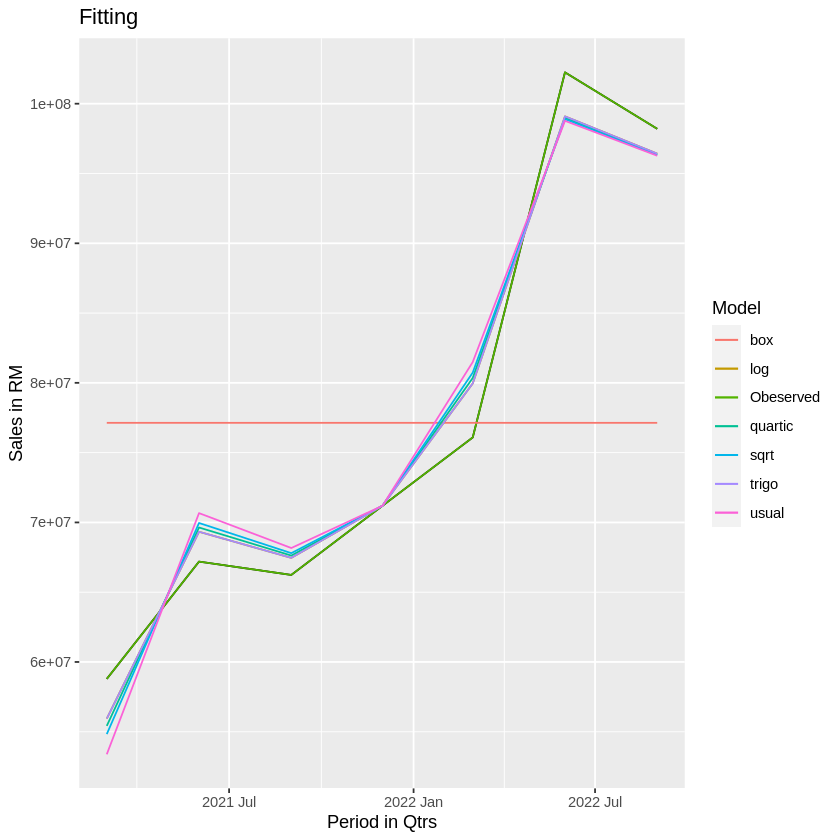

In [ ]:
yenherdata %>%
  autoplot(Sales) +
  geom_line(aes(y = Sales, colour = 'Obeserved')) +
  geom_line(aes(y = .fitted, colour = .model), data = fitted(models)) +
  #autolayer(fc_trends, alpha = 0.5, level = 95) +
  xlab('Period in Qtrs') +
  ylab('Sales in RM') +
  ggtitle('Fitting') +
  guides(colour = guide_legend(title = 'Model'))

Residual plots of the best model (Model diagnostic)

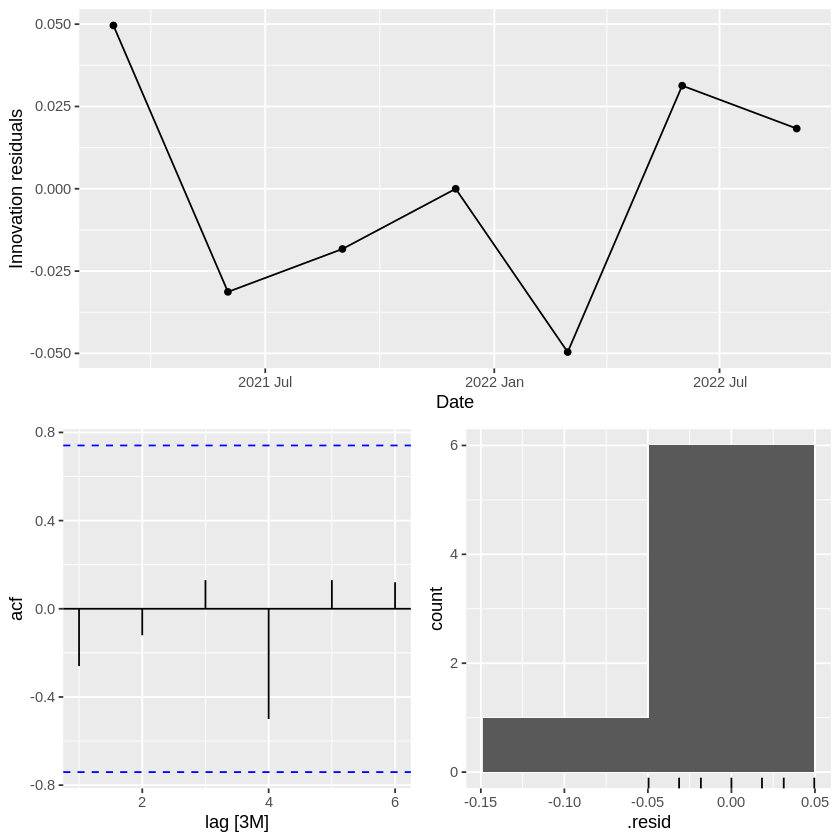

In [ ]:
select(models, log) %>% gg_tsresiduals

No spike at acf, within the blue interval signifies residuals do not correlate with each other.

Forecasting

.model,Date,Sales,.mean
<chr>,<mth>,<dist>,<dbl>
log,2022 Dec,"t(N(18, 0.01))",102272608
log,2023 Mar,"t(N(19, 0.011))",114932730
log,2023 Jun,"t(N(19, 0.011))",142438536
log,2023 Sep,"t(N(19, 0.011))",138596866
log,2023 Dec,"t(N(19, 0.018))",146729416
log,2024 Mar,"t(N(19, 0.021))",165097975
log,2024 Jun,"t(N(19, 0.021))",204609373
log,2024 Sep,"t(N(19, 0.021))",199090911


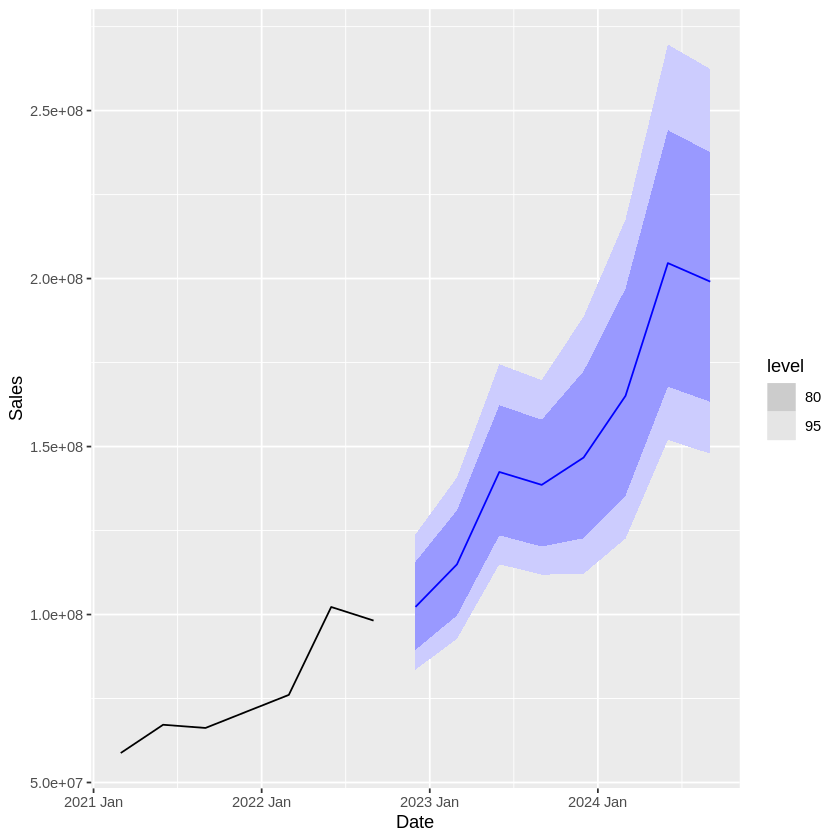

In [ ]:
select(models, log) %>% forecast(h = 8) %>% autoplot(yenherdata)
select(models, log) %>% forecast(h = 8) 

In [ ]:
modelsprofit = yenherdata %>% model(
    mean = MEAN(NetProfit),
    nnaive = NAIVE(NetProfit),
    snnaive = SNAIVE(NetProfit),
    randomwalk = RW(NetProfit),
    rwdrift = RW(NetProfit ~ drift()),
    usual = TSLM(NetProfit ~ trend() + season(period = 4)),
    log = TSLM(log(NetProfit) ~ trend() + season(period = 4)),
    sqrt = TSLM(sqrt(NetProfit) ~ trend() + season(period = 4)),
    quartic = TSLM(NetProfit^(1/4) ~ trend() + season(period = 4)),
    trigo = TSLM(log(NetProfit) ~ trend() + fourier(period = 4, K = 2)),
    box = ARIMA(NetProfit, stepwise = FALSE, approximation = FALSE)
)

In [ ]:
report(modelsprofit)

Warning message in report.mdl_df(modelsprofit):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,sigma2,r_squared,adj_r_squared,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<list>,<list>
mean,4.363218e+11,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
nnaive,1.646370e+12,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
snnaive,4.317737e+11,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
randomwalk,1.646370e+12,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
rwdrift,1.646370e+12,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
usual,2.158869e+11,0.8350706,0.5052118,2.531600,0.3026571,5,-96.890971,185.916802,Inf,185.592263,Inf,4.317737e+11,2,5,NULL,NULL
log,9.347900e-03,0.8076702,0.4230106,2.099701,0.3476688,5,10.806213,-29.477566,Inf,-29.802105,Inf,1.869580e-02,2,5,NULL,NULL
sqrt,1.122127e+04,0.8215205,0.4645615,2.301442,0.3251041,5,-38.187383,68.509626,Inf,68.185087,Inf,2.244255e+04,2,5,NULL,NULL
quartic,1.279957e+00,0.8146262,0.4438785,2.197252,0.3363842,5,-6.411793,4.958447,Inf,4.633908,Inf,2.559915e+00,2,5,NULL,NULL


In [ ]:
accuracy(modelsprofit)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean,Training,0.000000e+00,611547.3,535965.7,-1.3968776,10.402708,1.1885645,0.8858478,-0.61498362
nnaive,Training,8.869300e+04,1174666.4,1117414.3,-0.8651557,21.323299,2.4779924,1.7015456,-0.82038999
snnaive,Training,4.344393e+05,690352.6,450935.3,7.8323865,8.168158,1.0000000,1.0000000,-0.09976163
randomwalk,Training,8.869300e+04,1174666.4,1117414.3,-0.8651557,21.323299,2.4779924,1.7015456,-0.82038999
rwdrift,Training,0.000000e+00,1171313.2,1117414.3,-2.5319321,21.489130,2.4779924,1.6966884,-0.82038999
usual,Training,0.000000e+00,248358.5,215055.6,-0.2677746,4.261737,0.4769101,0.3597561,-0.09976163
log,Training,6.140240e+03,260099.3,229992.4,-0.1335935,4.489784,0.5100341,0.3767629,-0.11942860
sqrt,Training,3.206078e+03,253399.5,221976.5,-0.1985148,4.366356,0.4922579,0.3670580,-0.10914427
quartic,Training,4.715258e+03,256526.7,225839.3,-0.1653727,4.425582,0.5008241,0.3715879,-0.11418689


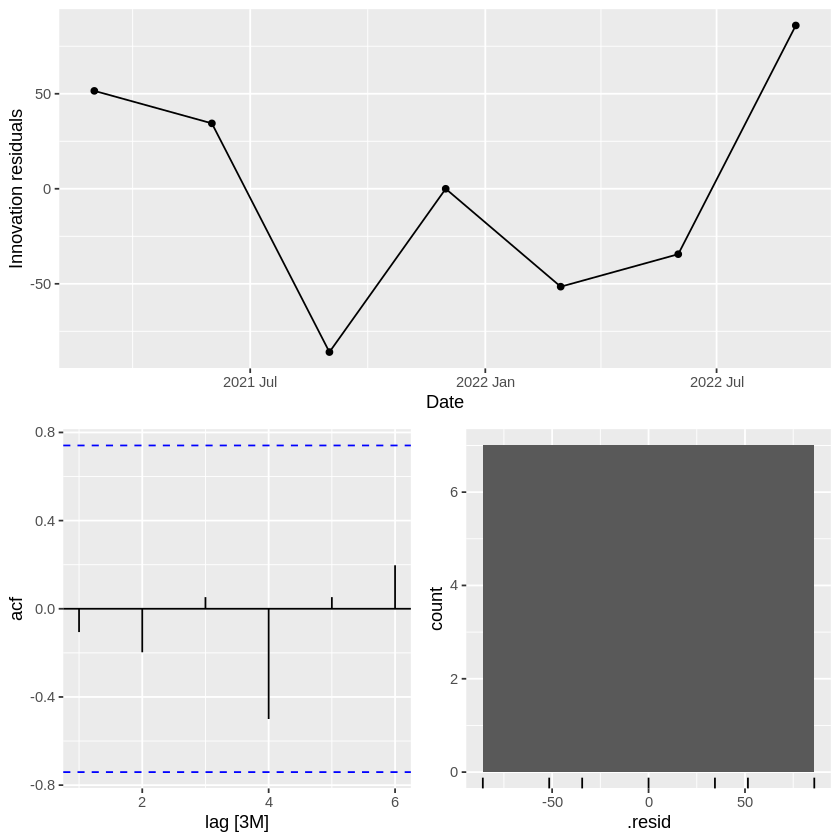

In [ ]:
select(modelsprofit, sqrt) %>% gg_tsresiduals

Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


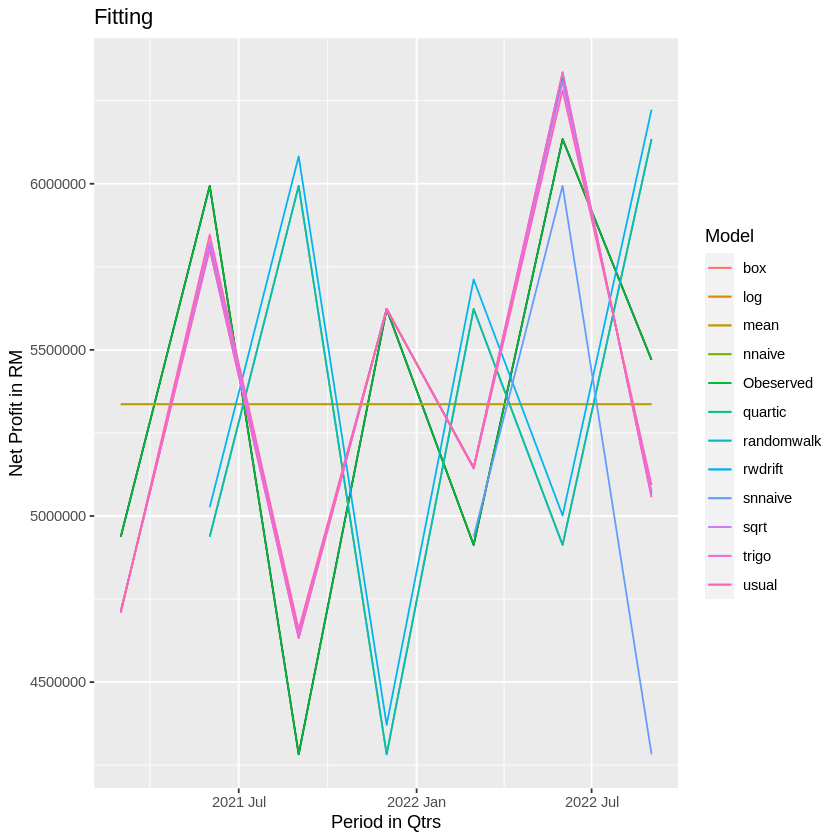

In [ ]:
yenherdata %>%
  autoplot(NetProfit) +
  geom_line(aes(y = NetProfit, colour = 'Obeserved')) +
  geom_line(aes(y = .fitted, colour = .model), data = fitted(modelsprofit)) +
  #autolayer(fc_trends, alpha = 0.5, level = 95) +
  xlab('Period in Qtrs') +
  ylab('Net Profit in RM') +
  ggtitle('Fitting') +
  guides(colour = guide_legend(title = 'Model'))

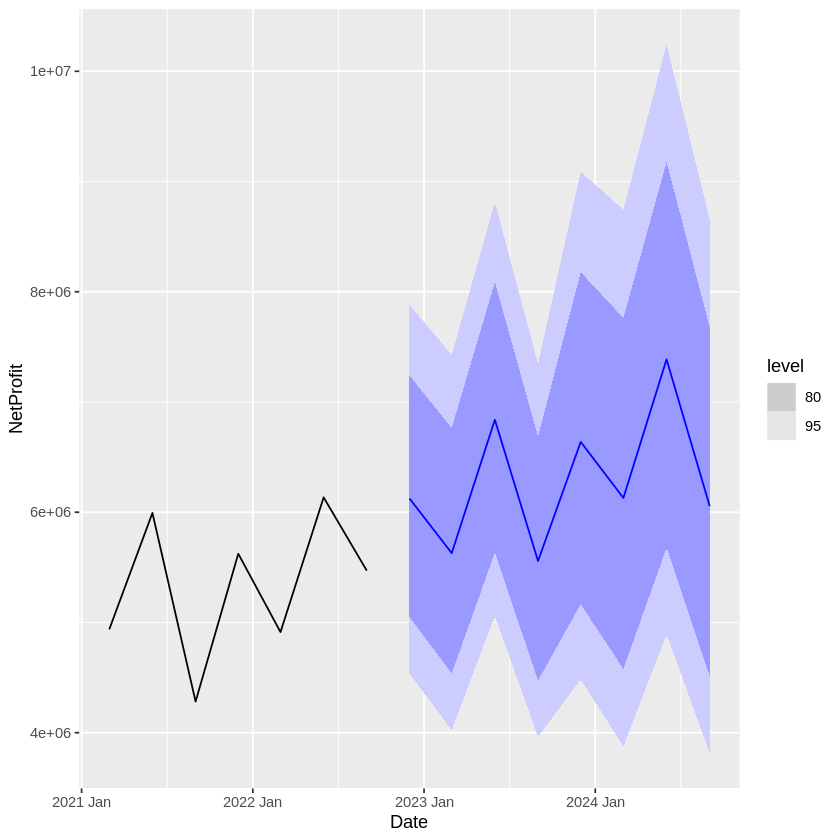

In [ ]:
select(modelsprofit, sqrt) %>% forecast(h = 8) %>% autoplot(yenherdata)

# Forecasting Yenher's share price

In [ ]:
getSymbols('AAPL', from = as.Date('2020-01-01'), to = as.Date('2023-02-24'))

[1] "AAPL"

In [ ]:
chartSeries('AAPL')

ERROR: ignored

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“NAs introduced by coercion”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: ignored

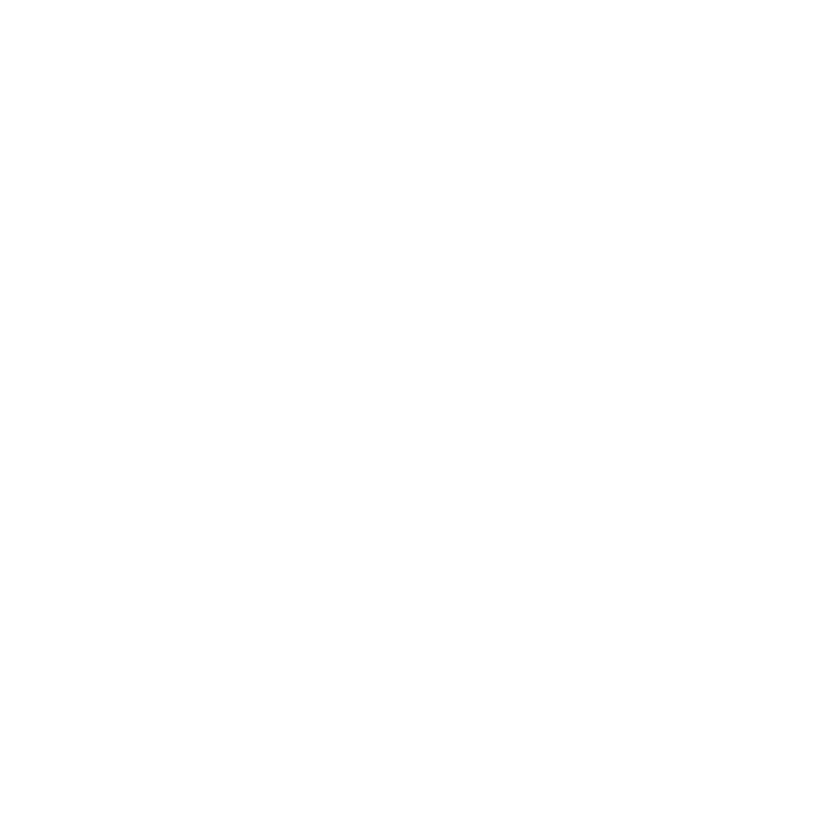

In [ ]:
plot('AAPL')

In [ ]:
data = getSymbols('5300.KL')

In [ ]:
df =  data.frame(Date = index(data), Coredata(data))

ERROR: ignored